# Expected Goals Model
### Zach Andrews
### ztandrews18@sbcglobal.net
### github.com/ztandrews
---
#### About

##### This notebook houses the expected goals model creation code. I use my xG model for my [website]( https://statsbyzach-app.hf.space/home/), where I use the data to help understand the NHL in a smarter way. I'm uploading this notebook to GitHub on it's own to give everyone a clean, concise look at how the xG model was created, which can help provide a better understanding of the metrics I post on the site.

#### Why CatBoost?
##### I ended up going with the CatBoost Classifier because, along with giving me the best results out of other classifiers, it works very well with categorical data, of which there is a lot within my features. CatBoost is a very fast boosting algorithm, which made it an appealing choice and ultimately what I went with for the creation of the model.

#### The Data
##### The data I used to build this model with is sourced from the [Hockey-Scraper](https://github.com/HarryShomer/Hockey-Scraper) Python package, which I used to scrape every shot since 2010. Once I got the data, I extensively pre-processed it by feature engineering and cleaning up the data to prepare it for modeling. Note that the workbook to do this is not public yet, but I am actively working to make it a little cleaner so I can upload it.

#### Other Notes
##### Again, this notebook is just the creation of the model. Furthermore, I trimmed down the book a bit to make it easier to read and see how everything is working. I have a few separate books where I tested different algorithms, different features, and different evaluation methods, but this notebook only contains a clean version of the final model that I actually use. If you'd like to know more about how I reached a final decision on the features and algorithm of choice, feel free to reach out! Also, I have an automated process that applies the final model to every single shot taken in every NHL game that gets played in real time, which is how I add more data to my code base. 

In [100]:
#Import Modules
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
#Read in data. This was pre-processed extensively in another file
allshots = pd.read_pickle("../season_shots/all_shots_clean.pickle")
allshots

,pbp_ID,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,...,strength_Short_Handed,is_5v4_pp,is_5v3_pp,teamCodeAgainst,farAngle,slot_chance,house_chance,goalieAgainst,lastEvent_WithTeam,Unnamed: 0.1
4,4,20003,2010-10-07,1,SHOT,"CAR ONGOAL - #12 STAAL, Snap, Off. Zone, 37 ft.",1:05,65.0,5x5,Off,...,0,0,0,MIN,15.524111,0,1,NIKLAS BACKSTROM,Faceoff,NaN
5,5,20003,2010-10-07,1,MISS,"CAR #6 GLEASON, Wrist, Wide of Net, Off. Zone,...",1:16,76.0,5x5,Off,...,0,0,0,MIN,23.749494,0,0,NIKLAS BACKSTROM,SameTeamShot,NaN
9,9,20003,2010-10-07,1,MISS,"MIN #23 NYSTROM, Wrist, Wide of Net, Off. Zone...",1:37,97.0,5x5,Off,...,0,0,0,CAR,14.620874,1,1,CAM WARD,Faceoff,NaN
17,17,20003,2010-10-07,1,GOAL,"MIN #48 LATENDRESSE(1), Wrist, Off. Zone, 12 f...",3:33,213.0,5x5,Off,...,0,0,0,CAR,5.355825,1,1,CAM WARD,Faceoff,NaN
23,23,20003,2010-10-07,1,SHOT,"MIN ONGOAL - #8 BURNS, Wrist, Off. Zone, 52 ft.",3:53,233.0,5x5,Off,...,0,0,0,CAR,34.159695,0,0,CAM WARD,Faceoff,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436796,436796,30415,2023-06-13,3,MISS,"FLA #94 LOMBERG, Backhand, Wide of Net, Off. Z...",16:01,961.0,5x5,Off,...,0,0,0,VGK,40.601295,0,0,ADIN HILL,SameTeamTake,436796.0
436797,436797,30415,2023-06-13,3,MISS,"FLA #12 STAAL, Slap, Wide of Net, Off. Zone, 4...",16:06,966.0,5x5,Off,...,0,0,0,VGK,8.365886,0,0,ADIN HILL,SameTeamMiss,436797.0
436805,436805,30415,2023-06-13,3,SHOT,"FLA ONGOAL - #28 MAHURA, Wrist, Def. Zone, 126...",17:59,1079.0,5x5,Def,...,0,0,0,VGK,25.974394,0,0,ADIN HILL,SameTeamGive,436805.0
436813,436813,30415,2023-06-13,3,SHOT,"VGK ONGOAL - #27 THEODORE, Wrist, Off. Zone, 6...",18:55,1135.0,5x5,Off,...,0,0,0,FLA,22.729732,0,0,SERGEI BOBROVSKY,Other,436813.0


In [101]:
#Select data to build model witha. Since we are using CatBoost, we can use categorical data
model_data_cat = allshots[['Period','xCordAdjusted','yCordAdjusted','isHomeTeam','shotDistance','shotAngle','goal','lastEventxCordAdjusted','lastEventyCordAdjusted', 'lastEvent_WithTeam',
                           'distanceFromLast','timeSinceLastEvent','Type','Strength_Mapped']]
model_data_cat

,Period,xCordAdjusted,yCordAdjusted,isHomeTeam,shotDistance,shotAngle,goal,lastEventxCordAdjusted,lastEventyCordAdjusted,lastEvent_WithTeam,distanceFromLast,timeSinceLastEvent,Type,Strength_Mapped
4,1,56.0,-15.0,0,36.249138,24.443955,0,20.0,-22.0,Faceoff,36.674242,57.0,SNAP SHOT,even
5,1,35.0,33.0,0,63.285069,31.429566,0,56.0,-15.0,SameTeamShot,52.392748,11.0,WRIST SHOT,even
9,1,87.0,-6.0,1,6.324555,71.565051,0,20.0,22.0,Faceoff,72.615425,13.0,WRIST SHOT,even
17,1,78.0,3.0,1,11.401754,15.255119,1,-69.0,22.0,Faceoff,148.222805,25.0,WRIST SHOT,even
23,1,54.0,38.0,1,51.662365,47.353297,0,69.0,22.0,Faceoff,21.931712,3.0,WRIST SHOT,even
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436796,3,82.0,-24.0,0,25.000000,73.739795,0,1.0,1.0,SameTeamTake,84.770278,9.0,BACKHAND,even
436797,3,42.0,10.0,0,48.052055,12.011478,0,82.0,-24.0,SameTeamMiss,52.497619,5.0,SLAP SHOT,even
436805,3,-32.0,38.0,0,126.826653,33.690068,0,-71.0,-39.0,SameTeamGive,86.313383,22.0,WRIST SHOT,even
436813,3,36.0,31.0,1,61.400326,30.323607,0,59.0,23.0,Other,24.351591,4.0,WRIST SHOT,even


In [102]:
#Train test split
X = model_data_cat[model_data_cat.columns.difference(['goal'])][100000:1262657]
y = model_data_cat[['goal']][100000:1262657]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=29)

In [58]:
#Designate cat features
categorical_features_indices = np.where(X.dtypes != np.float)[0]

C:\Users\ztand\AppData\Local\Temp\ipykernel_19296\3883311976.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X.dtypes != np.float)[0]


In [103]:
#Create grid to grid search
grid = {'random_strength': [1,2,3,4,5],'l2_leaf_reg':[10],'learning_rate':[.01,.05,.1,.25],'iterations':[25,50,75,100,],'depth':[3,4,5,7,10],'eval_metric':['AUC']}

In [ ]:
#Random grid search. Hiding output because it's massive lol
classifier = CatBoostClassifier(cat_features=categorical_features_indices)
random_search=RandomizedSearchCV(classifier,param_distributions=grid,n_iter=75,scoring='roc_auc',n_jobs=4,cv=10,verbose=3)
random_search.fit(X_train,y_train)

In [62]:
#Model with params from grid search. Re making it because the book crashed and I do not want to run the grid search again
model = CatBoostClassifier(iterations=100,learning_rate=.25,depth=10,l2_leaf_reg=10,random_strength=1,eval_metric='AUC')

In [63]:
#Fit model
model.fit(X_train, y_train,cat_features=categorical_features_indices)

0:	total: 221ms	remaining: 21.8s
1:	total: 443ms	remaining: 21.7s
2:	total: 682ms	remaining: 22s
3:	total: 918ms	remaining: 22s
4:	total: 1.13s	remaining: 21.6s
5:	total: 1.34s	remaining: 21s
6:	total: 1.51s	remaining: 20.1s
7:	total: 1.76s	remaining: 20.3s
8:	total: 1.97s	remaining: 19.9s
9:	total: 2.22s	remaining: 20s
10:	total: 2.43s	remaining: 19.7s
11:	total: 2.65s	remaining: 19.5s
12:	total: 2.89s	remaining: 19.4s
13:	total: 3.12s	remaining: 19.2s
14:	total: 3.35s	remaining: 19s
15:	total: 3.58s	remaining: 18.8s
16:	total: 3.8s	remaining: 18.5s
17:	total: 4s	remaining: 18.2s
18:	total: 4.22s	remaining: 18s
19:	total: 4.44s	remaining: 17.7s
20:	total: 4.65s	remaining: 17.5s
21:	total: 4.88s	remaining: 17.3s
22:	total: 5.09s	remaining: 17s
23:	total: 5.3s	remaining: 16.8s
24:	total: 5.53s	remaining: 16.6s
25:	total: 5.75s	remaining: 16.4s
26:	total: 5.97s	remaining: 16.1s
27:	total: 6.25s	remaining: 16.1s
28:	total: 6.49s	remaining: 15.9s
29:	total: 6.71s	remaining: 15.7s
30:	total

In [64]:
#Pred
preds_class = model.predict(X_test)

In [104]:
#Pred proba. The xG value is the prob that the shot belongs to the 1 class (is a goal)
preds_proba = model.predict_proba(X_test)

Text(0.5, 1.0, 'Feature Importance')

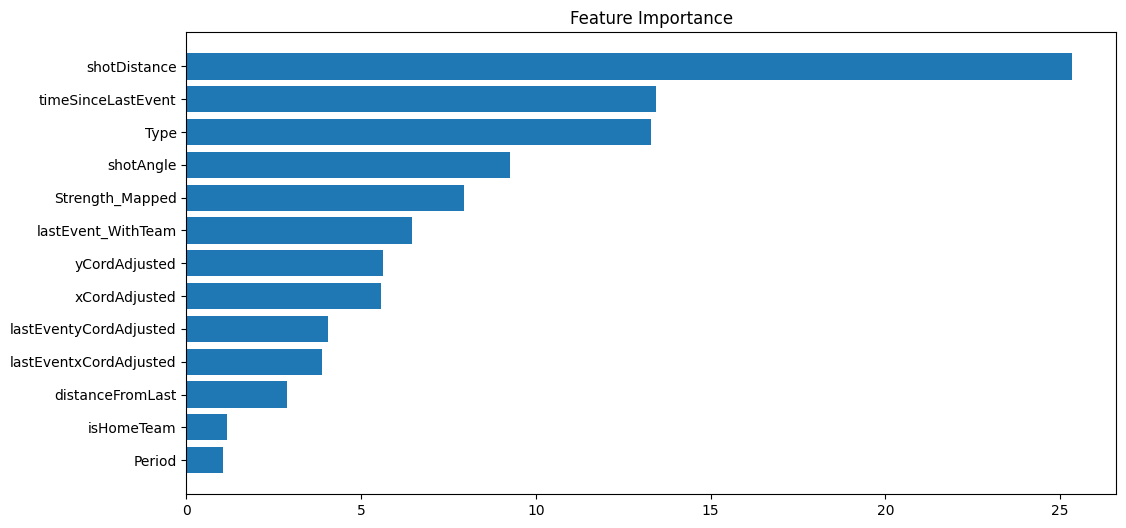

In [105]:
#Chart feature importance
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [72]:
#AUC score on testing data
print("\nAUC Score:")
print(roc_auc_score(y_test.values.ravel(), preds_proba[:,1], multi_class='ovr'))


AUC Score:
0.7721837937718786


In [73]:
#Lets join back the full dataframe with xG valeus so we can further validate the model

In [74]:
X = model_data_cat[model_data_cat.columns.difference(['goal'])]
y = model_data_cat[['goal']]

In [75]:
#Create a new data frame to add all shots with their xG values to
X_with_xgoals = X
X_with_xgoals = X_with_xgoals.reset_index()
X_with_xgoals

,index,Period,Strength_Mapped,Type,distanceFromLast,isHomeTeam,lastEvent_WithTeam,lastEventxCordAdjusted,lastEventyCordAdjusted,shotAngle,shotDistance,timeSinceLastEvent,xCordAdjusted,yCordAdjusted
0,4,1,even,SNAP SHOT,36.674242,0,Faceoff,20.0,-22.0,24.443955,36.249138,57.0,56.0,-15.0
1,5,1,even,WRIST SHOT,52.392748,0,SameTeamShot,56.0,-15.0,31.429566,63.285069,11.0,35.0,33.0
2,9,1,even,WRIST SHOT,72.615425,1,Faceoff,20.0,22.0,71.565051,6.324555,13.0,87.0,-6.0
3,17,1,even,WRIST SHOT,148.222805,1,Faceoff,-69.0,22.0,15.255119,11.401754,25.0,78.0,3.0
4,23,1,even,WRIST SHOT,21.931712,1,Faceoff,69.0,22.0,47.353297,51.662365,3.0,54.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374604,436796,3,even,BACKHAND,84.770278,0,SameTeamTake,1.0,1.0,73.739795,25.000000,9.0,82.0,-24.0
1374605,436797,3,even,SLAP SHOT,52.497619,0,SameTeamMiss,82.0,-24.0,12.011478,48.052055,5.0,42.0,10.0
1374606,436805,3,even,WRIST SHOT,86.313383,0,SameTeamGive,-71.0,-39.0,33.690068,126.826653,22.0,-32.0,38.0
1374607,436813,3,even,WRIST SHOT,24.351591,1,Other,59.0,23.0,30.323607,61.400326,4.0,36.0,31.0


In [76]:
#Predict the xG value for every shot taken from 2010-2021
all_xg = model.predict_proba(X)[:,1]
all_xg

array([0.05005276, 0.00795554, 0.06840634, ..., 0.0044816 , 0.01320383,
       0.26697745])

In [77]:
#Create data frame of every xG value
all_xg_df = pd.DataFrame(all_xg,columns=['xG'])
all_xg_df

,xG
0,0.050053
1,0.007956
2,0.068406
3,0.142906
4,0.017271
...,...
1374604,0.014786
1374605,0.034946
1374606,0.004482
1374607,0.013204


In [78]:
#Join shots with their xG values based on index
merged = X_with_xgoals.join(all_xg_df)
merged

,index,Period,Strength_Mapped,Type,distanceFromLast,isHomeTeam,lastEvent_WithTeam,lastEventxCordAdjusted,lastEventyCordAdjusted,shotAngle,shotDistance,timeSinceLastEvent,xCordAdjusted,yCordAdjusted,xG
0,4,1,even,SNAP SHOT,36.674242,0,Faceoff,20.0,-22.0,24.443955,36.249138,57.0,56.0,-15.0,0.050053
1,5,1,even,WRIST SHOT,52.392748,0,SameTeamShot,56.0,-15.0,31.429566,63.285069,11.0,35.0,33.0,0.007956
2,9,1,even,WRIST SHOT,72.615425,1,Faceoff,20.0,22.0,71.565051,6.324555,13.0,87.0,-6.0,0.068406
3,17,1,even,WRIST SHOT,148.222805,1,Faceoff,-69.0,22.0,15.255119,11.401754,25.0,78.0,3.0,0.142906
4,23,1,even,WRIST SHOT,21.931712,1,Faceoff,69.0,22.0,47.353297,51.662365,3.0,54.0,38.0,0.017271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374604,436796,3,even,BACKHAND,84.770278,0,SameTeamTake,1.0,1.0,73.739795,25.000000,9.0,82.0,-24.0,0.014786
1374605,436797,3,even,SLAP SHOT,52.497619,0,SameTeamMiss,82.0,-24.0,12.011478,48.052055,5.0,42.0,10.0,0.034946
1374606,436805,3,even,WRIST SHOT,86.313383,0,SameTeamGive,-71.0,-39.0,33.690068,126.826653,22.0,-32.0,38.0,0.004482
1374607,436813,3,even,WRIST SHOT,24.351591,1,Other,59.0,23.0,30.323607,61.400326,4.0,36.0,31.0,0.013204


In [79]:
full_data = allshots

In [80]:
full_data

,pbp_ID,Game_Id,Date,Period,Event,Description,Time_Elapsed,Seconds_Elapsed,Strength,Ev_Zone,...,strength_Short_Handed,is_5v4_pp,is_5v3_pp,teamCodeAgainst,farAngle,slot_chance,house_chance,goalieAgainst,lastEvent_WithTeam,Unnamed: 0.1
4,4,20003,2010-10-07,1,SHOT,"CAR ONGOAL - #12 STAAL, Snap, Off. Zone, 37 ft.",1:05,65.0,5x5,Off,...,0,0,0,MIN,15.524111,0,1,NIKLAS BACKSTROM,Faceoff,NaN
5,5,20003,2010-10-07,1,MISS,"CAR #6 GLEASON, Wrist, Wide of Net, Off. Zone,...",1:16,76.0,5x5,Off,...,0,0,0,MIN,23.749494,0,0,NIKLAS BACKSTROM,SameTeamShot,NaN
9,9,20003,2010-10-07,1,MISS,"MIN #23 NYSTROM, Wrist, Wide of Net, Off. Zone...",1:37,97.0,5x5,Off,...,0,0,0,CAR,14.620874,1,1,CAM WARD,Faceoff,NaN
17,17,20003,2010-10-07,1,GOAL,"MIN #48 LATENDRESSE(1), Wrist, Off. Zone, 12 f...",3:33,213.0,5x5,Off,...,0,0,0,CAR,5.355825,1,1,CAM WARD,Faceoff,NaN
23,23,20003,2010-10-07,1,SHOT,"MIN ONGOAL - #8 BURNS, Wrist, Off. Zone, 52 ft.",3:53,233.0,5x5,Off,...,0,0,0,CAR,34.159695,0,0,CAM WARD,Faceoff,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436796,436796,30415,2023-06-13,3,MISS,"FLA #94 LOMBERG, Backhand, Wide of Net, Off. Z...",16:01,961.0,5x5,Off,...,0,0,0,VGK,40.601295,0,0,ADIN HILL,SameTeamTake,436796.0
436797,436797,30415,2023-06-13,3,MISS,"FLA #12 STAAL, Slap, Wide of Net, Off. Zone, 4...",16:06,966.0,5x5,Off,...,0,0,0,VGK,8.365886,0,0,ADIN HILL,SameTeamMiss,436797.0
436805,436805,30415,2023-06-13,3,SHOT,"FLA ONGOAL - #28 MAHURA, Wrist, Def. Zone, 126...",17:59,1079.0,5x5,Def,...,0,0,0,VGK,25.974394,0,0,ADIN HILL,SameTeamGive,436805.0
436813,436813,30415,2023-06-13,3,SHOT,"VGK ONGOAL - #27 THEODORE, Wrist, Off. Zone, 6...",18:55,1135.0,5x5,Off,...,0,0,0,FLA,22.729732,0,0,SERGEI BOBROVSKY,Other,436813.0


In [81]:
#Combine the merged set with data from even_strength_shots, which contains relevent game information
full_data = full_data.reset_index()
full_data = full_data[['Game_Id','Date','Event','goal','Home_Team','Away_Team','Ev_Team','Away_Players','Home_Players','Home_Score','Away_Score','homeSkatersOnIce','awaySkatersOnIce',
                      'awayPlayer1','awayPlayer1_id','awayPlayer2','awayPlayer2_id','awayPlayer3','awayPlayer3_id','awayPlayer4',
                       'awayPlayer4_id','awayPlayer5','awayPlayer5_id','awayPlayer6','awayPlayer6_id',
                       'homePlayer1','homePlayer1_id','homePlayer2','homePlayer2_id','homePlayer3','homePlayer3_id','homePlayer4','homePlayer4_id',
                       'homePlayer5','homePlayer5_id','homePlayer6','homePlayer6_id','Home_Goalie','Home_Goalie_Id','Away_Goalie',
                      'Away_Goalie_Id','Home_Coach','Away_Coach','gameSeconds','p1_name','p1_ID','p2_name','p2_ID','p3_name','p3_ID','Description','goalieAgainst','farAngle','slot_chance','house_chance','teamCodeAgainst']]
full_data

,Game_Id,Date,Event,goal,Home_Team,Away_Team,Ev_Team,Away_Players,Home_Players,Home_Score,...,p2_name,p2_ID,p3_name,p3_ID,Description,goalieAgainst,farAngle,slot_chance,house_chance,teamCodeAgainst
0,20003,2010-10-07,SHOT,0,MIN,CAR,CAR,6,6,0,...,NaN,NaN,NaN,NaN,"CAR ONGOAL - #12 STAAL, Snap, Off. Zone, 37 ft.",NIKLAS BACKSTROM,15.524111,0,1,MIN
1,20003,2010-10-07,MISS,0,MIN,CAR,CAR,6,6,0,...,NaN,NaN,NaN,NaN,"CAR #6 GLEASON, Wrist, Wide of Net, Off. Zone,...",NIKLAS BACKSTROM,23.749494,0,0,MIN
2,20003,2010-10-07,MISS,0,MIN,CAR,MIN,6,6,0,...,NaN,NaN,NaN,NaN,"MIN #23 NYSTROM, Wrist, Wide of Net, Off. Zone...",CAM WARD,14.620874,1,1,CAR
3,20003,2010-10-07,GOAL,1,MIN,CAR,MIN,6,6,0,...,MIKKO KOIVU,8469459.0,KYLE BRODZIAK,8470803.0,"MIN #48 LATENDRESSE(1), Wrist, Off. Zone, 12 f...",CAM WARD,5.355825,1,1,CAR
4,20003,2010-10-07,SHOT,0,MIN,CAR,MIN,6,6,1,...,NaN,NaN,NaN,NaN,"MIN ONGOAL - #8 BURNS, Wrist, Off. Zone, 52 ft.",CAM WARD,34.159695,0,0,CAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374604,30415,2023-06-13,MISS,0,VGK,FLA,FLA,6,6,8,...,NaN,NaN,NaN,NaN,"FLA #94 LOMBERG, Backhand, Wide of Net, Off. Z...",ADIN HILL,40.601295,0,0,VGK
1374605,30415,2023-06-13,MISS,0,VGK,FLA,FLA,6,6,8,...,NaN,NaN,NaN,NaN,"FLA #12 STAAL, Slap, Wide of Net, Off. Zone, 4...",ADIN HILL,8.365886,0,0,VGK
1374606,30415,2023-06-13,SHOT,0,VGK,FLA,FLA,6,6,8,...,NaN,NaN,NaN,NaN,"FLA ONGOAL - #28 MAHURA, Wrist, Def. Zone, 126...",ADIN HILL,25.974394,0,0,VGK
1374607,30415,2023-06-13,SHOT,0,VGK,FLA,VGK,6,6,8,...,NaN,NaN,NaN,NaN,"VGK ONGOAL - #27 THEODORE, Wrist, Off. Zone, 6...",SERGEI BOBROVSKY,22.729732,0,0,FLA


In [82]:
#Join based on index
full_merged_set = merged.join(full_data)
full_merged_set

,index,Period,Strength_Mapped,Type,distanceFromLast,isHomeTeam,lastEvent_WithTeam,lastEventxCordAdjusted,lastEventyCordAdjusted,shotAngle,...,p2_name,p2_ID,p3_name,p3_ID,Description,goalieAgainst,farAngle,slot_chance,house_chance,teamCodeAgainst
0,4,1,even,SNAP SHOT,36.674242,0,Faceoff,20.0,-22.0,24.443955,...,NaN,NaN,NaN,NaN,"CAR ONGOAL - #12 STAAL, Snap, Off. Zone, 37 ft.",NIKLAS BACKSTROM,15.524111,0,1,MIN
1,5,1,even,WRIST SHOT,52.392748,0,SameTeamShot,56.0,-15.0,31.429566,...,NaN,NaN,NaN,NaN,"CAR #6 GLEASON, Wrist, Wide of Net, Off. Zone,...",NIKLAS BACKSTROM,23.749494,0,0,MIN
2,9,1,even,WRIST SHOT,72.615425,1,Faceoff,20.0,22.0,71.565051,...,NaN,NaN,NaN,NaN,"MIN #23 NYSTROM, Wrist, Wide of Net, Off. Zone...",CAM WARD,14.620874,1,1,CAR
3,17,1,even,WRIST SHOT,148.222805,1,Faceoff,-69.0,22.0,15.255119,...,MIKKO KOIVU,8469459.0,KYLE BRODZIAK,8470803.0,"MIN #48 LATENDRESSE(1), Wrist, Off. Zone, 12 f...",CAM WARD,5.355825,1,1,CAR
4,23,1,even,WRIST SHOT,21.931712,1,Faceoff,69.0,22.0,47.353297,...,NaN,NaN,NaN,NaN,"MIN ONGOAL - #8 BURNS, Wrist, Off. Zone, 52 ft.",CAM WARD,34.159695,0,0,CAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374604,436796,3,even,BACKHAND,84.770278,0,SameTeamTake,1.0,1.0,73.739795,...,NaN,NaN,NaN,NaN,"FLA #94 LOMBERG, Backhand, Wide of Net, Off. Z...",ADIN HILL,40.601295,0,0,VGK
1374605,436797,3,even,SLAP SHOT,52.497619,0,SameTeamMiss,82.0,-24.0,12.011478,...,NaN,NaN,NaN,NaN,"FLA #12 STAAL, Slap, Wide of Net, Off. Zone, 4...",ADIN HILL,8.365886,0,0,VGK
1374606,436805,3,even,WRIST SHOT,86.313383,0,SameTeamGive,-71.0,-39.0,33.690068,...,NaN,NaN,NaN,NaN,"FLA ONGOAL - #28 MAHURA, Wrist, Def. Zone, 126...",ADIN HILL,25.974394,0,0,VGK
1374607,436813,3,even,WRIST SHOT,24.351591,1,Other,59.0,23.0,30.323607,...,NaN,NaN,NaN,NaN,"VGK ONGOAL - #27 THEODORE, Wrist, Off. Zone, 6...",SERGEI BOBROVSKY,22.729732,0,0,FLA


In [83]:
shots = full_merged_set

In [84]:
shots_2022 = full_merged_set[1254732:1366684]

In [85]:
#Check AUC for 2022-2023 even strength shots. The model has not seen these shots yet, so anotyher good test case
yt2 = shots_2022[shots_2022['Strength_Mapped']=='even'][['goal']]
pred22 = shots_2022[shots_2022['Strength_Mapped']=='even'][['xG']]
print(roc_auc_score(yt2, pred22, multi_class='ovr')) #Not bad! I like it.

0.761152378214507


In [95]:
#Lets see which teams lead in even-strength xGF and xGA
xgf = pd.DataFrame(shots_2022[shots_2022['Strength_Mapped']=='even'].groupby("Ev_Team")['xG'].sum().sort_values()).reset_index()
xgf = xgf.rename(columns={'xG':'xGF'})
xga = pd.DataFrame(shots_2022[shots_2022['Strength_Mapped']=='even'].groupby("teamCodeAgainst")['xG'].sum().sort_values()).reset_index()
xga = xga.rename(columns={"teamCodeAgainst":"Ev_Team",'xG':'xGA'})

In [96]:
#Final df. Looks good to me
final  =xgf.merge(xga)
final.sort_values(by="xGF")

,Ev_Team,xGF,xGA
0,ARI,150.830355,190.170479
1,ANA,154.805713,230.457822
2,CHI,155.215642,203.729348
3,DET,156.455148,175.590594
4,MTL,162.318160,202.824339
5,STL,163.338340,197.472098
6,MIN,164.936436,163.526150
7,CBJ,166.655069,213.259467
8,VAN,167.414144,189.725721
9,PHI,168.507028,182.984033


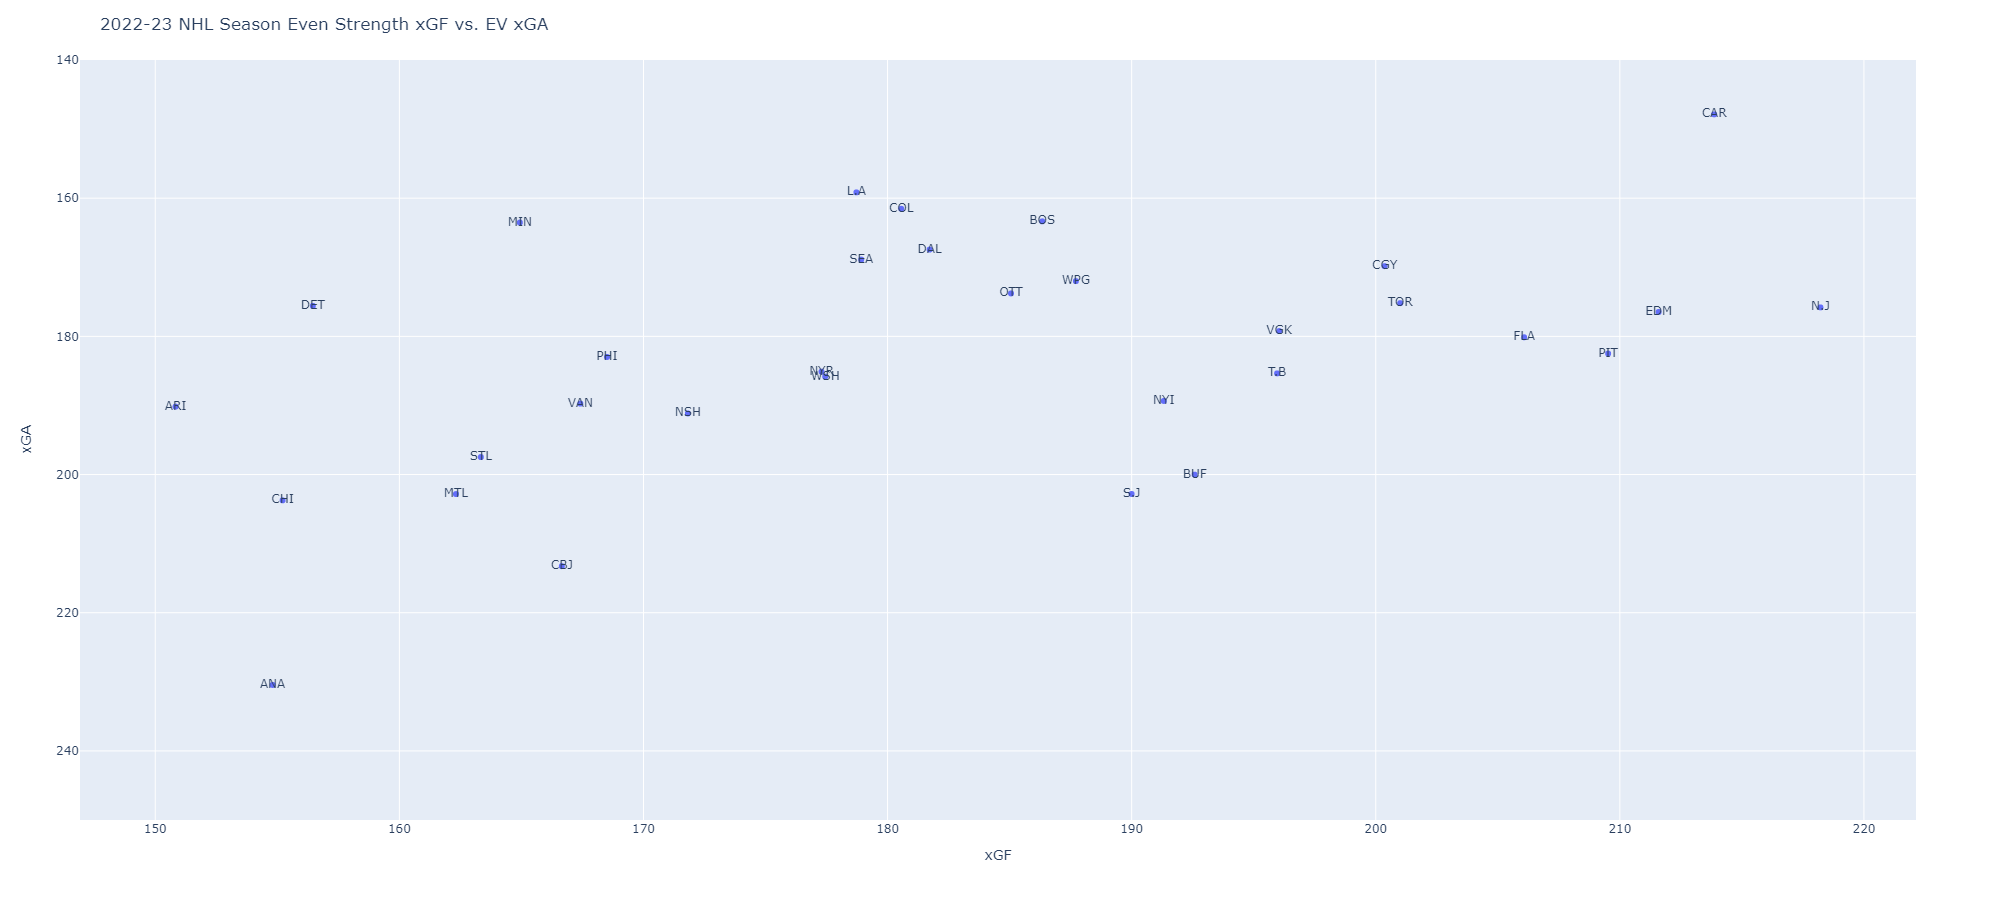

In [99]:
#Scatter of EV xGF vs xGA
fig = px.scatter(final,x='xGF',y='xGA',text="Ev_Team",width=900,height=900)
fig.update_layout(title="2022-23 NHL Season Even Strength xGF vs. EV xGA")
fig.update_layout(yaxis_range=[250,140])
fig.show()

In [59]:
#Wonderful. Looking great!
#Save model
filename = 'xG_model.sav'
pickle.dump(model, open(filename,'wb'))

In [37]:
#Save shots with their xG values to a picklle file
shots.to_pickle('../season_shots/full_shot_data.pickle')